In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG
from torchvision import transforms
from scipy import ndimage
from PIL import Image as pil
import numpy as np
from tqdm import tqdm
import ast

In [4]:
class UnNormalize(transforms.Normalize):
    def __init__(self,mean,std,*args,**kwargs):
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
model = vgg16(pretrained = True)
model = model.to(DEVICE)

In [8]:
model_modules = [m for m in list(model.features)]

In [9]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
normalize_imagenet_inv = UnNormalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

Старт оптимизации начнем с некоторого рандомного изображения

In [10]:
input_img = np.random.randn(224, 224, 3)
min_img = input_img.min(axis=0, keepdims=True).min(axis=1, keepdims=True)
max_img = input_img.max(axis=0, keepdims=True).max(axis=1, keepdims=True)
input_img = (255*(input_img-min_img)/(max_img-min_img)).astype(np.uint8)

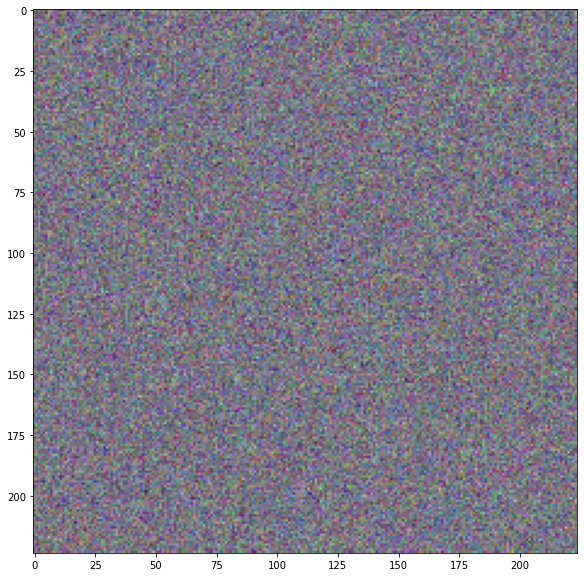

In [11]:
plt.imshow(input_img)

In [12]:
def make_torch_tensor_imagenet_normalized(img_np_float):
    x = transforms.ToPILImage()(img_np_float)
    x = transforms.ToTensor()(x)
    x = normalize_imagenet(x)
    x = torch.unsqueeze(x, 0)
    return x

In [13]:
def transform_back(img_tensor):
    x = torch.squeeze(img_tensor)
    x = normalize_imagenet_inv(x)
    x = x.detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (255*(x-x.min())/(x.max()-x.min())).astype(np.uint8)
    return x

In [14]:
input_img_tensor = make_torch_tensor_imagenet_normalized(input_img)

In [15]:
input_img_tensor = input_img_tensor.to(DEVICE)

обязательно укажем `pytorch` вычислять градиенты по этому тензору

In [16]:
input_img_tensor = input_img_tensor.requires_grad_(True)

In [17]:
input_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [18]:
layer_num = -1
feature_num = 383

In [86]:
submodel = torch.nn.Sequential(*list(model.features)[:(layer_num+1)])

In [19]:
# submodel = model

Прототипируем вычисления. Ниже мы их будет проводить итерационно, в цикле максимизации нужного нам признака.

In [ ]:
hidden_features = submodel(input_img_tensor)

In [ ]:
hidden_features.shape

In [ ]:
f1 = hidden_features[0,feature_num,:,:]

Средствами `pytorch` мы можем безболезненно считать градиенты только для скаляров. Поэтому сделаем из полученного признака скаляр - хотя бы осреднением.

In [ ]:
f1_mean = torch.mean(f1)

In [ ]:
f1_mean.backward()

In [ ]:
input_img_tensor.grad

In [ ]:
input_img_tensor.grad = -input_img_tensor.grad

In [ ]:
input_img_tensor.grad

In [20]:
opt = torch.optim.Adam([input_img_tensor], lr=0.5)

In [21]:
objective_history = []
# objective_history.append(float(f1_mean.detach().cpu().numpy()))

In [22]:
steps = 10000
each = 50

In [23]:
# Вариант для карт активации ранга 2 - вектор выходных значений оценки вероятности классов

with tqdm(total=steps, ncols=80, disable=False) as pbar:
    for i in range(steps):
        features = submodel(input_img_tensor)
        f1 = features[0,feature_num]
        f1_mean = torch.mean(f1)
        f2 = -(features[0,:feature_num].sum() + features[0,(feature_num+1):].sum())
        f1_mean_np = float(f1_mean.detach().cpu().numpy())
        f2_np = float(f2.detach().cpu().numpy())
        objective_history.append(f1_mean_np+f2_np)
        loss = f1_mean + f2_np
        loss.backward()
        input_img_tensor.grad = -input_img_tensor.grad
        opt.step()
        opt.zero_grad()
        pbar.update(1)
        pbar.set_postfix({'step': i, 'f1_mean': f1_mean_np})

100%|█████████| 10000/10000 [01:57<00:00, 85.03it/s, step=9999, f1_mean=1.79e+6]


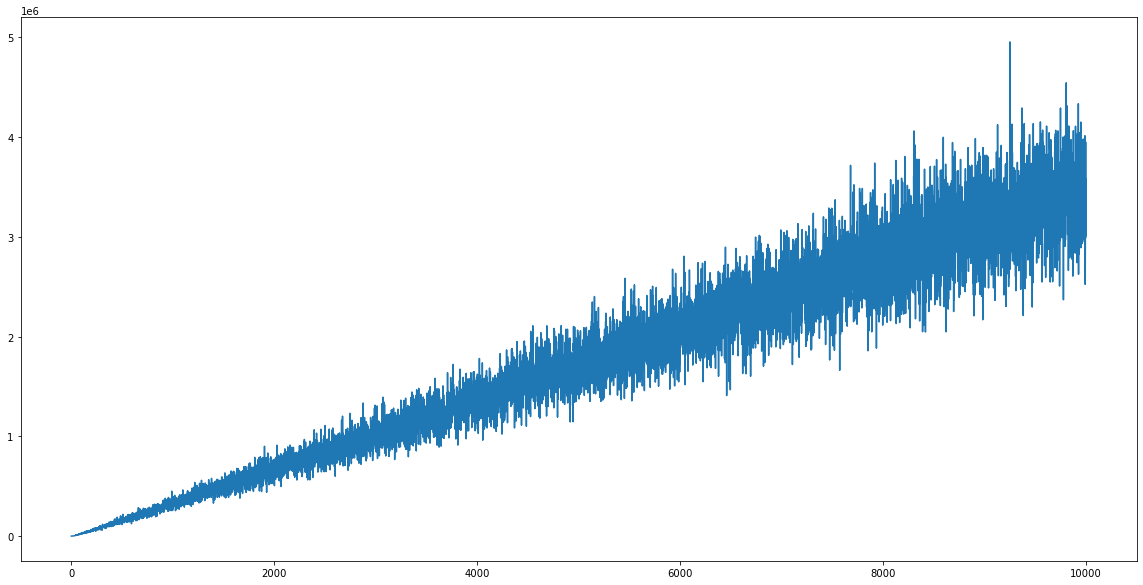

In [24]:
plt.plot(objective_history)

In [25]:
x = transform_back(input_img_tensor)

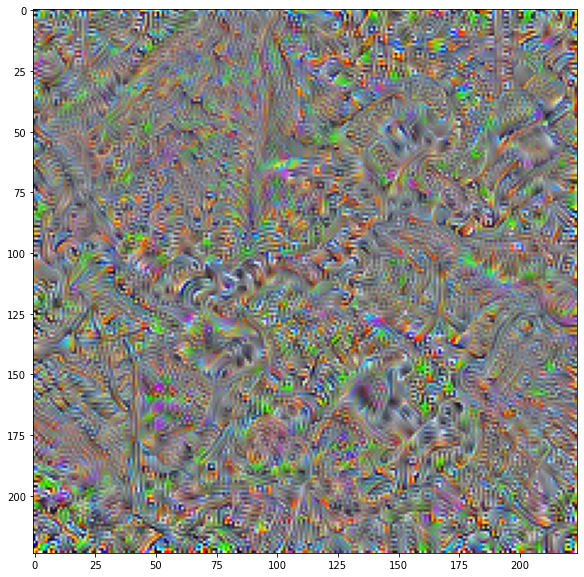

In [26]:
plt.imshow(x)

In [27]:
p = model(input_img_tensor)

In [28]:
p = p.detach().cpu().numpy()

In [29]:
np.argmax(p)

383

In [117]:
y = model(input_img_tensor)[0, 383]

In [119]:
(grad, ) = autograd.grad(y, inputs=input_img_tensor, create_graph=False)

In [120]:
grad.shape

torch.Size([1, 3, 224, 224])

In [130]:
mp = np.abs(grad.cpu().detach())

In [126]:
def tensor2image(image_tensor: torch.Tensor) -> np.ndarray:
    image_tensor = image_tensor[0]  # выбираем единственный элемент
    image_tensor = image_tensor.permute((1, 2, 0))  # [channels, height, width] -> [height, width, channels]
    image_numpy = image_tensor.detach().cpu().numpy()  # конвертируем в numpy
    return image_numpy

In [127]:
def renormalize_image(x: np.ndarray) -> np.ndarray: 
    x = (x - np.min(x)) 
    x = x / np.max(x) * 255

    return x.astype(np.uint8)

In [132]:
saliency_map = tensor2image(mp).max(-1)
# image = renormalize_image(tensor2image(img_tensor))

In [137]:
image = renormalize_image(tensor2image(input_img_tensor))

In [133]:
heatmap = ndimage.gaussian_filter(saliency_map[:,:,None] , 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

In [134]:
heatmap = renormalize_image(heatmap) / 255

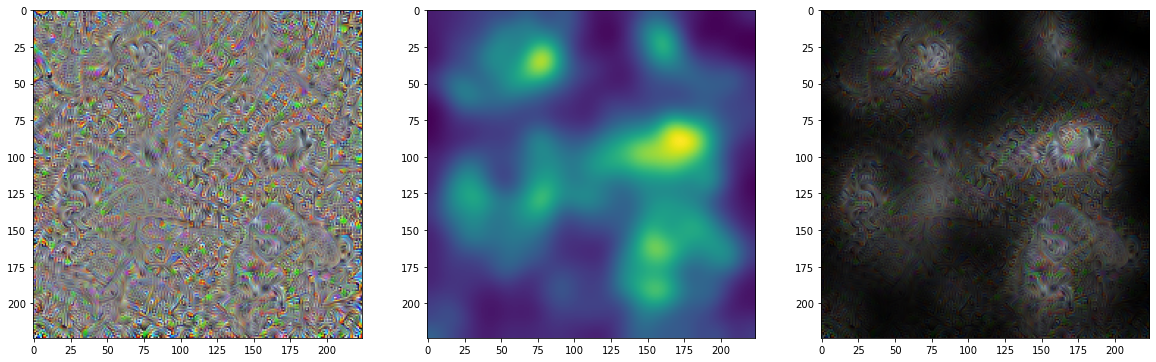

In [138]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.imshow(image)
ax = fig.add_subplot(1,3,2)
ax.imshow(heatmap[:,:,0])
ax = fig.add_subplot(1,3,3)
ax.imshow((image * heatmap).astype(np.uint8))